<a href="https://colab.research.google.com/github/Prashant1729/Sports-image-classifier/blob/main/Glass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
  
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip '/content/drive/My Drive/datasetsports.zip'

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/1073117687.jpg  
  inflating: dataset/train/e3ae2a9f6e.jpg  
  inflating: dataset/train/82d3416c00.jpg  
  inflating: dataset/train/66e9d02175.jpg  
  inflating: dataset/train/afec8505f7.jpg  
  inflating: dataset/train/cf2a5b233a.jpg  
  inflating: dataset/train/c37abcc137.jpg  
  inflating: dataset/train/8bcbe06317.jpg  
  inflating: dataset/train/caca99dc21.jpg  
  inflating: dataset/train/e9b32794ca.jpg  
  inflating: dataset/train/637586c0ff.jpg  
  inflating: dataset/train/35a32aac13.jpg  
  inflating: dataset/train/b1311604f0.jpg  
  inflating: dataset/train/bf10970e45.jpg  
  inflating: dataset/train/2eb4bef7ed.jpg  
  inflating: dataset/train/b7b2cdbd3f.jpg  
  inflating: dataset/train/52718c34ef.jpg  
  inflating: dataset/train/7d41e944ed.jpg  
  inflating: dataset/train/1329ba1d09.jpg  
  inflating: dataset/train/7e56dad7c9.jpg  
  inflating: dataset/train/0bf0d06450.jpg  
  inflating: dataset/trai

In [ ]:
train_path = '/content/dataset/train'
test_path = '/content/dataset/test'

In [ ]:
data = pd.read_csv("/content/dataset/train.csv")
data.head(5)

,image_ID,label
0,7c225f7b61.jpg,Badminton
1,b31.jpg,Badminton
2,acb146546c.jpg,Badminton
3,0e62f4d8f2.jpg,Badminton
4,cfd2c28c74.jpg,Cricket


In [ ]:
data['label'].unique()

array(['Badminton', 'Cricket', 'Tennis', 'Swimming', 'Soccer',
       'Wrestling', 'Karate'], dtype=object)

In [ ]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                  validation_split=0.2 # training: 80% data, validation: 20% data
                 )
  
train_generator = gen.flow_from_dataframe(
    data, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'image_ID',
    y_col = 'label',
    subset="training",
    color_mode="rgb",
    target_size = (150,150), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 6582 validated image filenames belonging to 7 classes.


In [ ]:
  
validation_generator = gen.flow_from_dataframe(
    data, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'image_ID',
    y_col = 'label',
    subset="validation",
    color_mode="rgb",
    target_size = (150,150), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42)

Found 1645 validated image filenames belonging to 7 classes.


In [ ]:
import cv2
  
import warnings
warnings.filterwarnings('ignore')

In [ ]:
x,y = next(train_generator)
x.shape

(32, 150, 150, 3)

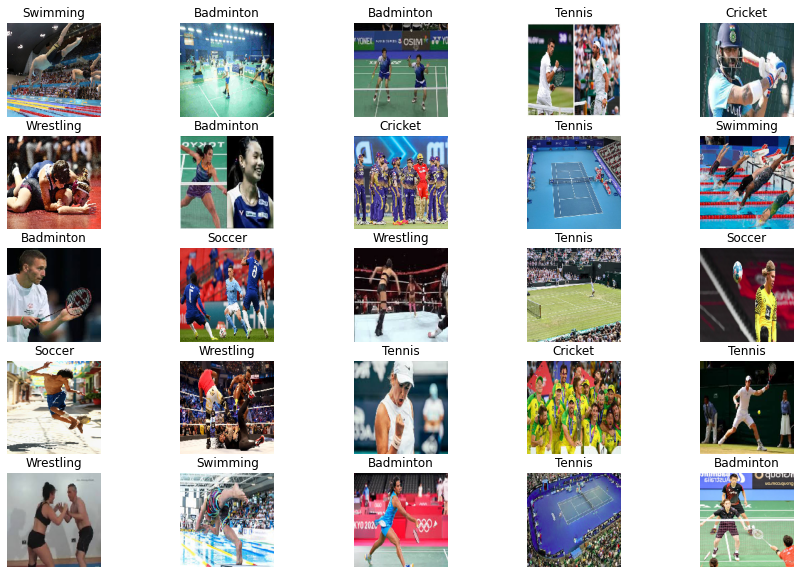

In [ ]:
import matplotlib.pyplot as plt

a = train_generator.class_indices
class_names = list(a.keys())

def plot_images(img,labels):
    plt.figure(figsize=[15,10])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
          
plot_images(x,y)

In [ ]:

# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(150,150,3)
                     )
  
base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
  
model = tf.keras.Sequential([ 
        base_model,   
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(7, activation='softmax')
    ])

219070464/219055592 [==============================] - 1s 0us/step


In [ ]:
from keras import backend as K


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=[f1])
# categorical cross entropy is taken since its used as a loss function for 
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 3, 3, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [ ]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)
# early stopping call back

In [ ]:
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
  
# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=[early])

Epoch 1/25
205/205 [==============================] - 91s 344ms/step - loss: 1.4469 - f1: 0.3636 - val_loss: 0.8403 - val_f1: 0.6599
Epoch 2/25
205/205 [==============================] - 65s 317ms/step - loss: 0.9318 - f1: 0.6677 - val_loss: 0.5900 - val_f1: 0.7955
Epoch 3/25
205/205 [==============================] - 64s 314ms/step - loss: 0.7316 - f1: 0.7506 - val_loss: 0.5566 - val_f1: 0.8147
Epoch 4/25
205/205 [==============================] - 64s 312ms/step - loss: 0.6255 - f1: 0.7918 - val_loss: 0.5329 - val_f1: 0.8192
Epoch 5/25
205/205 [==============================] - 64s 313ms/step - loss: 0.5635 - f1: 0.8191 - val_loss: 0.5045 - val_f1: 0.8253
Epoch 6/25
205/205 [==============================] - 63s 309ms/step - loss: 0.5239 - f1: 0.8327 - val_loss: 0.5453 - val_f1: 0.8169
Epoch 7/25
205/205 [==============================] - 63s 309ms/step - loss: 0.4427 - f1: 0.8530 - val_loss: 0.5101 - val_f1: 0.8351
Epoch 8/25
205/205 [==============================] - 64s 311ms/step 

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9707144498825073\nValidation Accuracy: 0.8822138905525208')

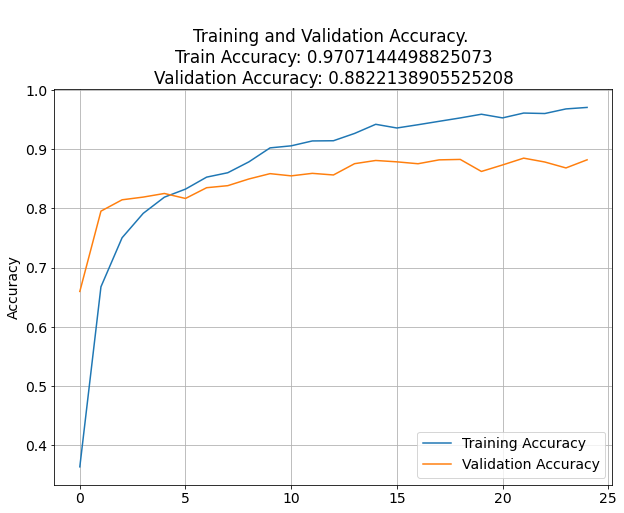

In [ ]:
# store results
acc = history.history['f1']
val_acc = history.history['val_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']
  
  
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

In [ ]:
model.save("Model.h5")

In [ ]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100)) 
  
print("Loss: ",accuracy_score[0])

52/52 [==============================] - 14s 265ms/step - loss: 0.6693 - f1: 0.8781
[0.6692655086517334, 0.8781305551528931]
Accuracy: 87.8131%
Loss:  0.6692655086517334


In [ ]:
test = pd.read_csv('/content/dataset/test.csv')
test.head(5)

,image_ID
0,f5e13966e7.jpg
1,6674191b4e.jpg
2,91b5f8b7a9.jpg
3,393119b6d6.jpg
4,1ce5f81578.jpg


In [ ]:
labels = ['Badminton','Cricket','Karate','Soccer','Swimming','Tennis','Wrestling']
predictions = []
  
for image in test.image_ID:
    img = tf.keras.preprocessing.image.load_img(test_path +'/'+ image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (150,150))
    img = tf.reshape(img, (-1,150,150, 3))
    prediction = model.predict(img/255)
    #print(labels[np.argmax(prediction)])
    predictions.append(labels[np.argmax(prediction)])


In [ ]:
my_submission = pd.DataFrame({'image_ID': test.image_ID, 'label':  predictions})
my_submission.head(5)

,image_ID,label
0,f5e13966e7.jpg,Soccer
1,6674191b4e.jpg,Tennis
2,91b5f8b7a9.jpg,Badminton
3,393119b6d6.jpg,Wrestling
4,1ce5f81578.jpg,Badminton


In [ ]:
my_submission.to_csv('submission_file.csv',index = False)

In [ ]:
a = pd.read_csv("/content/submission_file.csv")
a.head(5)

,image_ID,label
0,f5e13966e7.jpg,Soccer
1,6674191b4e.jpg,Tennis
2,91b5f8b7a9.jpg,Badminton
3,393119b6d6.jpg,Wrestling
4,1ce5f81578.jpg,Badminton
